## 1 Импорт библиотек и модулей

In [1]:
!pip install -q ydata_profiling

In [2]:
#!pip install -q hyperopt

In [3]:
%matplotlib inline 

In [4]:
# для обработки ошибок 
import warnings

# для работы с данными
import pandas as pd

# для EDA анализа
import ydata_profiling

# для математических вычислений
import numpy as np

# для разделения данных на выборки
from sklearn.model_selection import train_test_split

# для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# для кодирования данных
from sklearn.preprocessing import OneHotEncoder

# для масштабирования признаков
from sklearn.preprocessing import RobustScaler

# модели машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# для подсчёта точности модели
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

# константная модель
from sklearn.dummy import DummyClassifier

# для перемешивания данных
from sklearn.utils import shuffle

# для подбора гиперпараметров
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

## 2 Открытие файла с данными и изучение общей информации
Считаем данные из csv-файла в датафрейм и сохраним в переменную `df` и проведём EDA анализ.

In [2]:
def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv')
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv')
    ydata_profiling.ProfileReport(df, progress_bar=False).to_file(name + '.html')
    return df

In [5]:
df = read_eda('Churn')

[Посмотреть анализ.](https://www.dropbox.com/s/l3lcdqo89aendnt/Churn.html?dl=0)

- **В данных 10000 строк, 14 столбцов, 3 типа данных: float64, int64, object.**
- **Присутствуют пропуски в столбце `Tenure`.**
- **По графикам видно, что в столбцах `CreditScore`, `Age` и `NumOfProducts` присутствуют выбросы.**
- **Также, виден сильный дисбаланс классов в целевом признаке.**

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>После изучения данных, стала ясна их общая структура:</b> 10000 строк, 14 столбцов, 3 типа данных: float64, int64, object.<br> <b>Также были обнаружены данные, подлежащие обработке:</b>
        <li>Пропуски в столбце "Tenure".</li>
        <li>Выбросы в столбцах "CreditScore", "Age" и "NumOfProducts".</li>
        <li>Дисбаланс классов в целевом признаке.</li>
    </p>  
</div>

## 3 Подготовка данных
### 3.1 Удаление столбцов
Столбцы `RowNumber`, `CustomerId` и `Surname` содержат идентификационные переменные, которые не помогут модели в нахождении общих закономерностей, поэтому удалим их.

In [47]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

### 3.2 Обработка пропусков
При [изучении данных](#ginf) были обнаружены пропуски в столбце `Tenure`, проверим уникальные значения этого столбца.

In [48]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Столбец содержит целые значения, возможно пропуски возникли из-за того, что люди являются клиентами банка меньше года, заменим на 0.

In [49]:
df['Tenure'] = df['Tenure'].fillna(0)

### 3.3 Разбивка
Разобьём данные на признаки (`x`) и целевой признак (`y`).

In [50]:
x = df.drop('Exited', axis=1)
y = df['Exited']

Разобьём данные на обучающую, валидационную и тестовую выборки.

In [51]:
RANDOM_STATE = 0

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, 
                                                    random_state=RANDOM_STATE, stratify=y_valid)

Проверим размеры выборок.

In [52]:
print('Размер обучающей выборки:', x_train.shape)
print('Размер валидационной выборки:', x_valid.shape)
print('Размер тестовой выборки:', x_test.shape)

Размер обучающей выборки: (7500, 10)
Размер валидационной выборки: (1500, 10)
Размер тестовой выборки: (1000, 10)


### 3.4 Кодирование
Проверим, признаки какого типа хранятся в таблице.

In [53]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Тип столбцов `Geography` и `Gender` — object, значит они содержат категориальные переменные. Такие значения не поддерживаются многими моделями машинного обучения, закодируем их техникой прямого кодирования (она подходит для всех моделей).

In [54]:
categorical_columns = ['Geography', 'Gender']
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                  'EstimatedSalary']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder.fit(x_train[categorical_columns])

def ohe(x):
    x_encoded = pd.DataFrame(
        encoder.transform(x[categorical_columns]).toarray(),
        columns=encoder.get_feature_names_out(categorical_columns),
        index=x.index
    )
    x = pd.concat((x[numeric_columns], x_encoded), axis=1)
    return x

x_train = ohe(x_train)
x_valid = ohe(x_valid)
x_test = ohe(x_test)

### 3.5 Масштабирование признаков
На гистограммах столбцов были замечены выбросы, проверим их наличие на диаграммах размаха.

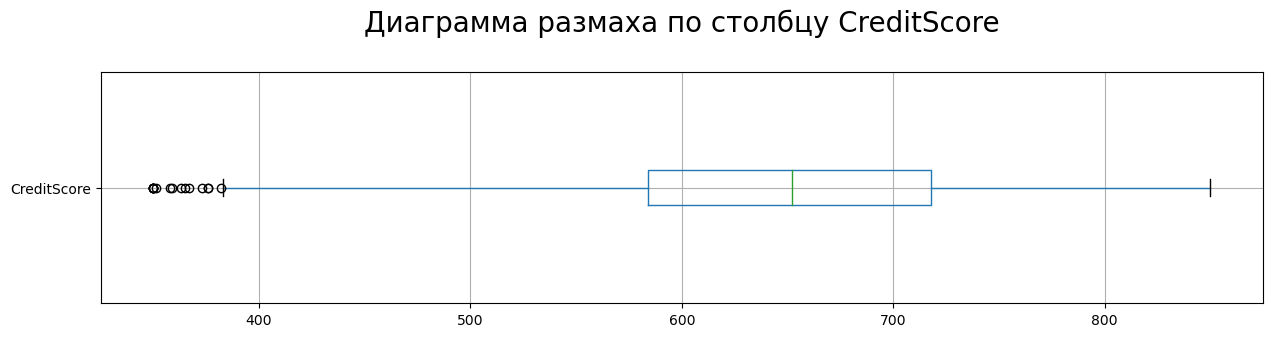

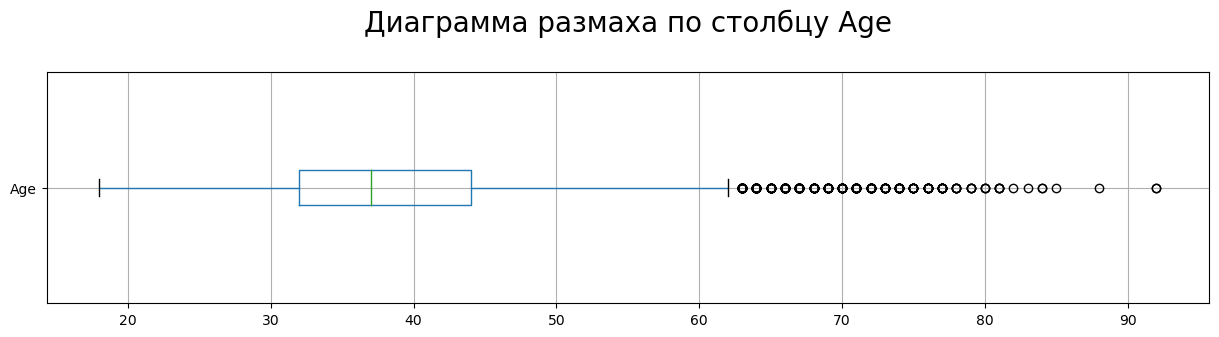

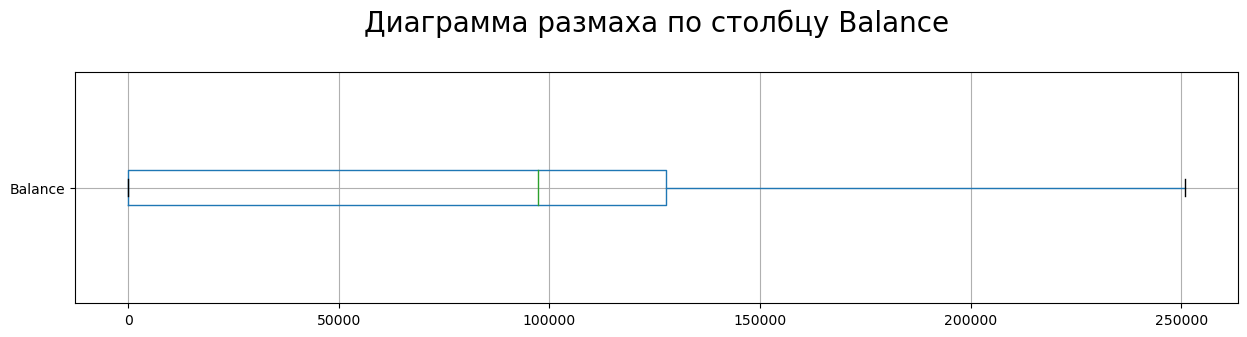

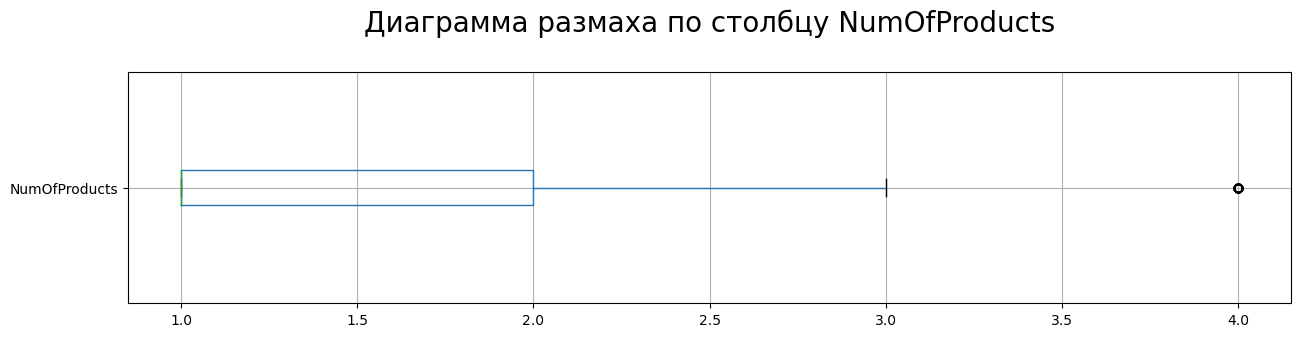

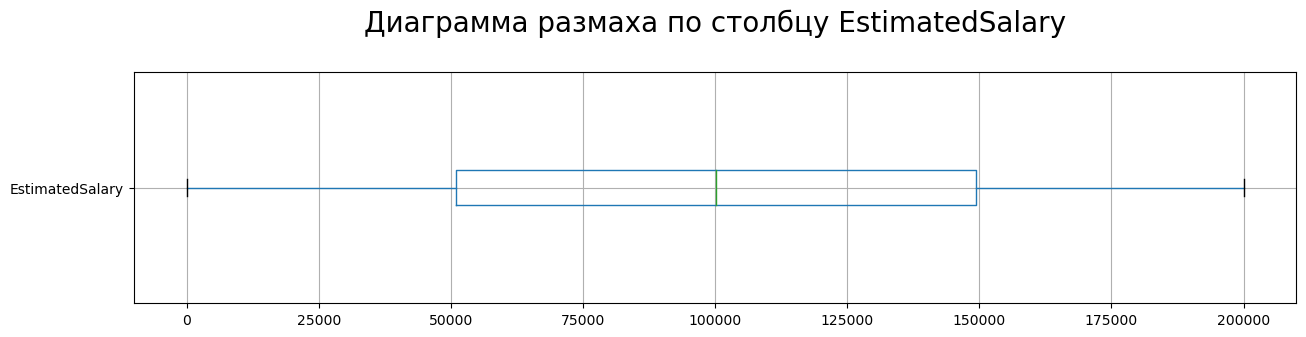

In [55]:
columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

for column in columns:
    (
        df
        .boxplot(column=column, figsize=(15, 3), vert=False)
        .set_title('Диаграмма размаха по столбцу ' + column + "\n", size=20)
    )
    plt.show()

В столбцах `CreditScore`, `Age` и `NumOfProducts` правда присутствуют выбросы, поэтому используем устойчивый к выбросам `RobustScaler` ([сравнение масштабаторов на данных с выбросами](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)), чтобы признаки стали равными по значимости.

In [57]:
pd.options.mode.chained_assignment = None

scaler = RobustScaler()
scaler.fit(x_train[columns])
x_train[columns] = scaler.transform(x_train[columns])
x_valid[columns] = scaler.transform(x_valid[columns])
x_test[columns] = scaler.transform(x_test[columns])

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты подготовки данных:</b>
        <ol>
        <li>Удалены ненужные столбцы.</li>
        <li>Обработаны пропуски.</li>
        <li>Закодированы категориальные переменные.</li>
        <li>Данные разбиты на выборки.</li>
        <li>Численные признаки масштабированы.</li>
        </ol>
   </p>  
</div>

## 4 Исследование задачи
На гистограмме целевого признака был замечен сильный дисбаланс классов, проверим это.

Обучим и оценим модели без учёта дисбаланса классов.

In [18]:
lgr = LogisticRegression(random_state=RANDOM_STATE, max_iter=300)
lgr.fit(x_train, y_train)
lgr_predictions = lgr.predict(x_valid)
print(accuracy_score(y_valid, lgr_predictions))

0.8086666666666666


In [19]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(x_train, y_train)
dt_predictions = dt.predict(x_valid)
print(accuracy_score(y_valid, dt_predictions))

0.7953333333333333


In [20]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(x_train, y_train)
rf_predictions = rf.predict(x_valid)
print(accuracy_score(y_valid, rf_predictions))

0.8546666666666667


Проверим модели на адекватность с помощью фиктивного классификатора. 

In [21]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(x_train, y_train)
dummy_predictions = dummy.predict(x_valid)
print(accuracy_score(y_valid, dummy_predictions))

0.7966666666666666


<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Разница точностей моделей и фиктивного классификатора меньше 0.1, следовательно, в данных присутствует сильный дисбаланс классов, что плохо сказывается на обучении моделей.</b>
   </p>  
</div>

## 5 Борьба с дисбалансом
Проверим, какой метод борьбы с дисбалансом даст лучшие оценки.

Выведем оценки без учёта дисбаланса классов.

In [22]:
f1_without = {}
auc_without = {}

In [23]:
def scores(mdl, x_train=x_train, y_train=y_train, class_weight=None, f1_dict=f1_without, auc_dict=auc_without):
    try:
        model = mdl(solver='liblinear', class_weight=class_weight, random_state=RANDOM_STATE)
    except:
        model = mdl(class_weight=class_weight, random_state=RANDOM_STATE)
        
    model.fit(x_train, y_train)
    predictions = model.predict(x_valid)
    f1 = f1_score(y_valid, predictions)
    auc = roc_auc_score(y_valid, model.predict_proba(x_valid)[:, 1])
    
    mdl = type(model).__name__
        
    f1_dict[mdl] = f1
    auc_dict[mdl] = auc
    print(mdl + "\n" + 'F1:', f1, "\n" + 'AUC-ROC:', auc, "\n")

In [24]:
models = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier]

for model in models:
    scores(mdl=model)

LogisticRegression
F1: 0.308433734939759 
AUC-ROC: 0.7676054599080869 

DecisionTreeClassifier
F1: 0.5225505443234837 
AUC-ROC: 0.7042801289526031 

RandomForestClassifier
F1: 0.5532786885245902 
AUC-ROC: 0.8435530557651416 



### 5.1 Взвешивание классов
Добавим в модели параметр `class_weight='balanced'` и посчитаем оценки.

In [25]:
f1_weighted = {}
auc_weighted = {}

for model in models:
    scores(mdl=model, class_weight='balanced', f1_dict=f1_weighted, auc_dict=auc_weighted)

LogisticRegression
F1: 0.502283105022831 
AUC-ROC: 0.7696467521777899 

DecisionTreeClassifier
F1: 0.5156794425087109 
AUC-ROC: 0.6919953357569106 

RandomForestClassifier
F1: 0.5305263157894737 
AUC-ROC: 0.8408176143768433 



F1-мера

- Оценка логистической регрессии увеличилась примерно на 0.2.
- Оценки дерева решений и случайного леса незначительно уменьшились.

AUC-ROC

- Оценки логистической регрессии и случайного леса остались примерно на том же уровне.
- Оценка дерева решений незначительно уменьшилась.

### 5.2 Увеличение выборки
Увеличим недостающий класс.

In [26]:
def upsample(x, y):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    repeat = round(len(x_zeros) / len(x_ones))

    x_upsampled = pd.concat([x_zeros] + [x_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    x_upsampled, y_upsampled = shuffle(x_upsampled, y_upsampled, random_state=RANDOM_STATE)
    return x_upsampled, y_upsampled

In [27]:
x_upsampled, y_upsampled = upsample(x_train, y_train)

Посчитаем оценки.

In [28]:
f1_upsampled = {}
auc_upsampled = {}

for model in models:
    scores(mdl=model, x_train=x_upsampled, y_train=y_upsampled, f1_dict=f1_upsampled, auc_dict=auc_upsampled)

LogisticRegression
F1: 0.5005636978579481 
AUC-ROC: 0.7695836477124631 

DecisionTreeClassifier
F1: 0.5180102915951972 
AUC-ROC: 0.6944029082927499 

RandomForestClassifier
F1: 0.5698529411764706 
AUC-ROC: 0.8441004184100419 



F1-мера

- Оценка логистической регрессии так же увеличилась примерно на 0.2, но меньше, чем при взвешевании классов.
- Оценка дерева решений так же незначительно уменьшилась, но меньше, чем при взвешевании классов.
- Оценка случайного леса незначительно увеличилась.

AUC-ROC

- Оценки логистической регрессии и случайного леса остались примерно на том же уровне.
- Оценка дерева решений незначительно уменьшилась, но меньше, чем при взвешевании классов.

### 5.3 Уменьшение выборки
Сократим преобладающий класс.

In [29]:
def downsample(x, y):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    fraction = len(x_ones) / len(x_zeros)

    x_downsampled = pd.concat([x_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [x_ones])
    y_downsampled = pd.concat([y_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [y_ones])
    
    x_downsampled, y_downsampled = shuffle(x_downsampled, y_downsampled, random_state=RANDOM_STATE)
    return x_downsampled, y_downsampled

In [30]:
x_downsampled, y_downsampled = downsample(x_train, y_train)

Посчитаем оценки.

In [31]:
f1_downsampled = {}
auc_downsampled = {}

for model in models:
    scores(mdl=model, x_train=x_downsampled, y_train=y_downsampled, f1_dict=f1_downsampled, auc_dict=auc_downsampled)

LogisticRegression
F1: 0.49382716049382713 
AUC-ROC: 0.7678002606488785 

DecisionTreeClassifier
F1: 0.4700239808153477 
AUC-ROC: 0.6819809314767817 

RandomForestClassifier
F1: 0.5825747724317295 
AUC-ROC: 0.8409095274024281 



F1-мера

- Оценка логистической регрессии так же увеличилась примерно на 0.2, но меньше, чем при увеличении выборки.
- Оценка дерева решений так же незначительно уменьшилась, но больше, чем при увеличении выборки.
- Оценка случайного леса так же незначительно увеличилась, но больше, чем при увеличении выборки.

AUC-ROC

- Оценки логистической регрессии и случайного леса остались примерно на том же уровне.
- Оценка дерева решений незначительно уменьшилась, но больше, чем при увеличении выборки.

### 5.4 Общие таблицы
Соединим предыдущие наблюдения по F1-мере в один датафрейм.

In [32]:
def dataframe(without, weighted, upsampled, downsampled):
    df = pd.DataFrame()

    dicts = [without, weighted, upsampled, downsampled]

    for dict in dicts:
        df = df.append(dict, ignore_index=True)
    
    df.index = ['Без учёта дисбаланса', 'Взвешивание классов', 'Увеличение выборки', ' Уменьшение выборки']
    return df

In [33]:
dataframe(f1_without, f1_weighted, f1_upsampled, f1_downsampled)

,DecisionTreeClassifier,LogisticRegression,RandomForestClassifier
Без учёта дисбаланса,0.522551,0.308434,0.553279
Взвешивание классов,0.515679,0.502283,0.530526
Увеличение выборки,0.518010,0.500564,0.569853
Уменьшение выборки,0.470024,0.493827,0.582575


Соединим предыдущие наблюдения по AUC-ROC в один датафрейм.

In [34]:
dataframe(auc_without, auc_weighted, auc_upsampled, auc_downsampled)

,DecisionTreeClassifier,LogisticRegression,RandomForestClassifier
Без учёта дисбаланса,0.704280,0.767605,0.843553
Взвешивание классов,0.691995,0.769647,0.840818
Увеличение выборки,0.694403,0.769584,0.844100
Уменьшение выборки,0.681981,0.767800,0.840910


<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Лучшие методы борьбы с дисбалансом:</b>
        <li>Для дерева решений — увеличение выборки.</li>
        <li>Для логистической регрессии — взвешивание классов.</li>
        <li>Для случайного леса — уменьшение выборки.</li>
    </p>  
</div>

## 6 Подбор порога классификации
Найдём лучший порог классификации для логистической регрессии.

In [35]:
def clf_threshold(mdl, x_train, y_train):
    
    if mdl == LogisticRegression:
        model = mdl(solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)
    else:
        model = mdl(random_state=RANDOM_STATE)
    
    model.fit(x_train, y_train)
    probabilities = model.predict_proba(x_valid)
    probabilities_one = probabilities[:, 1]
    
    best_f1 = 0
    best_threshold = 0

    for threshold in np.arange(0, 0.95, 0.05):
        predicted = probabilities_one > threshold
        precision = precision_score(y_valid, predicted)
        recall = recall_score(y_valid, predicted)
        f1 = f1_score(y_valid, predicted)
        
        if best_f1 < f1:
            best_f1 = f1
            best_threshold = threshold
    
    print('Лучшая F1-мера:', best_f1)
    print('AUC-ROC:', roc_auc_score(y_valid, probabilities_one)) 
    print('Лучший порог:', round(best_threshold, 2)) 
    
    label_size = 16
    title_size = 18
    
    precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_one)

    plt.figure(figsize=(6, 5))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall', size=label_size)
    plt.ylabel('Precision', size=label_size)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall', size=title_size)
    plt.show() 
    
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', size=label_size)
    plt.ylabel('True Positive Rate', size=label_size)
    plt.title('ROC-кривая', size=title_size)
    plt.show()

Лучшая F1-мера: 0.502283105022831
AUC-ROC: 0.7696467521777899
Лучший порог: 0.5


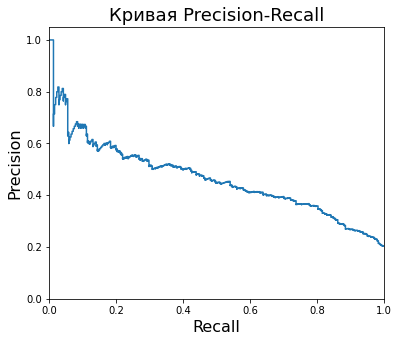

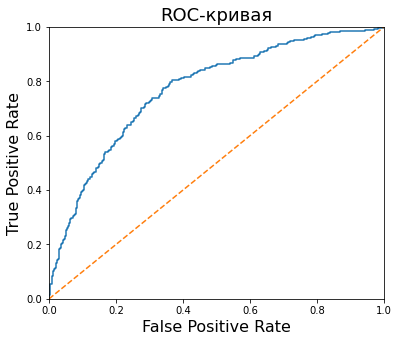

In [36]:
clf_threshold(mdl=LogisticRegression, x_train=x_train, y_train=y_train)

Найдём лучший порог классификации для дерева решений.

Лучшая F1-мера: 0.5180102915951972
AUC-ROC: 0.6944029082927499
Лучший порог: 0.0


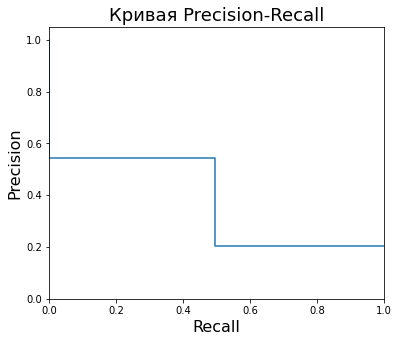

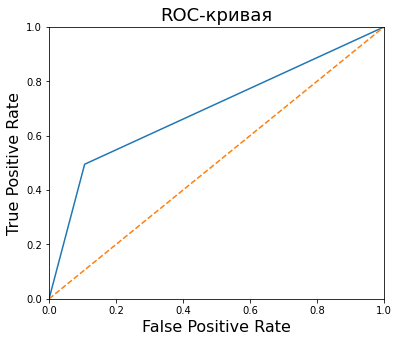

In [37]:
clf_threshold(mdl=DecisionTreeClassifier, x_train=x_upsampled, y_train=y_upsampled)

Найдём лучший порог классификации для случайного леса.

Лучшая F1-мера: 0.6076335877862596
AUC-ROC: 0.8409095274024281
Лучший порог: 0.6


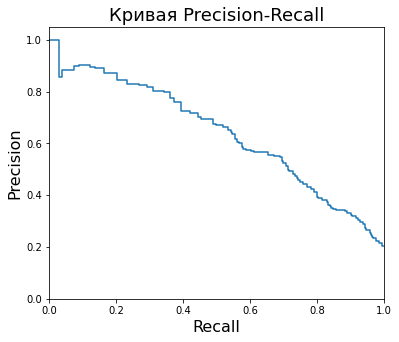

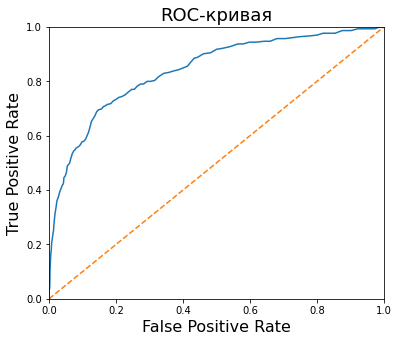

In [38]:
clf_threshold(mdl=RandomForestClassifier, x_train=x_downsampled, y_train=y_downsampled)

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Лучшие пороги классификации:</b>
        <li>Для логистической регрессии — 0.5.</li>
        <li>Для дерева решений — 0.</li>
        <li>Для случайного леса — 0.6.</li>
    </p>  
</div>

## 7 Подбор гиперпараметров
Найдём лучшие гиперпараметры для логистической регрессии с помощью байесовской оптимизации. 

In [39]:
def hyperparams_selections(mdl, x_train, y_train):
    def func(args):
        if mdl == LogisticRegression:
            model = mdl(C=args['C'], solver=args['solver'], 
                        tol=args['tol'], fit_intercept=args['fit_intercept'], 
                        max_iter=args['max_iter'], class_weight='balanced', random_state=RANDOM_STATE)
        elif mdl == DecisionTreeClassifier:
            model = mdl(max_depth=args['max_depth'], max_features=args['max_features'], 
                        criterion=args['criterion'], min_samples_split=args['min_samples_split'], 
                        min_samples_leaf=args['min_samples_leaf'], random_state=RANDOM_STATE)
        else:
            model = mdl(max_depth=args['max_depth'], max_features=args['max_features'], 
                        min_samples_split=args['min_samples_split'], 
                        min_samples_leaf=args['min_samples_leaf'], n_estimators=args['n_estimators'], 
                        random_state=RANDOM_STATE)
        model.fit(x_train, y_train)
        loss = -model.score(x_valid, y_valid)
        return {'loss': loss, 'status': STATUS_OK, 'model':model}
    
    trials = Trials()
    best = fmin(func,
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=10, 
                show_progressbar=True)
    best_model = trials.best_trial['result']['model']
    
    print('Лучшие гиперпараметры:', best)
    print('Точность обучения: %f' % best_model.score(x_train, y_train))
    print('Точность теста: %f' % best_model.score(x_valid, y_valid))
    return best

In [40]:
%%time

space = {
        'C': hp.uniform('C', 0.1, 2.0),
        'solver': hp.choice('solver', ['liblinear', 'lbfgs']),
        'tol': hp.loguniform('tol', np.log(1e-5), np.log(1e-2)),
        'fit_intercept': hp.choice('fit_intercept', [True, False]),
        'max_iter': scope.int(hp.quniform('max_iter', 50, 500, 20))
        }

best_lnr = hyperparams_selections(mdl=LogisticRegression, x_train=x_train, y_train=y_train)

100%|██████████| 10/10 [00:03<00:00,  2.89trial/s, best loss: -0.7113333333333334]
Лучшие гиперпараметры: {'C': 0.24936301801599606, 'fit_intercept': 1, 'max_iter': 140.0, 'solver': 1, 'tol': 0.00021095158295996686}
Точность обучения: 0.724667
Точность теста: 0.711333
CPU times: user 1.68 s, sys: 1.86 s, total: 3.54 s
Wall time: 3.56 s


Найдём лучшие гиперпараметры для дерева решений с помощью байесовской оптимизации.

In [41]:
%%time

space = {
        'max_depth': scope.int(hp.quniform('max_depth', 3, 100, 1)),
        'max_features': hp.choice('max_features', range(1,5)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]), 
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 50, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 50, 1))
        }

best_dt = hyperparams_selections(mdl=DecisionTreeClassifier, x_train=x_upsampled, y_train=y_upsampled)

100%|██████████| 10/10 [00:00<00:00, 36.51trial/s, best loss: -0.7886666666666666]
Лучшие гиперпараметры: {'criterion': 1, 'max_depth': 91.0, 'max_features': 2, 'min_samples_leaf': 2.0, 'min_samples_split': 26.0}
Точность обучения: 0.890599
Точность теста: 0.788667
CPU times: user 232 ms, sys: 77.9 ms, total: 310 ms
Wall time: 375 ms


Найдём лучшие гиперпараметры для случайного леса с помощью байесовской оптимизации.

In [42]:
%%time

space = {
        'max_depth': scope.int(hp.quniform('max_depth', 3, 100, 1)),
        'max_features': hp.choice('max_features', range(1,5)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 50, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 50, 1)), 
        'n_estimators': hp.choice('n_estimators', range(1,20))
        }

best_rf = hyperparams_selections(mdl=RandomForestClassifier, x_train=x_downsampled, y_train=y_downsampled)

100%|██████████| 10/10 [00:00<00:00, 26.33trial/s, best loss: -0.7706666666666667]
Лучшие гиперпараметры: {'max_depth': 94.0, 'max_features': 3, 'min_samples_leaf': 40.0, 'min_samples_split': 2.0, 'n_estimators': 15}
Точность обучения: 0.797448
Точность теста: 0.770667
CPU times: user 382 ms, sys: 12.3 ms, total: 395 ms
Wall time: 407 ms


<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>После подбора гиперпараметров, можно сделать такие выводы:</b>
        <li>Самая высокая точность у случайного леса, самая низкая у логистической регресии.</li>
        <li>Самое быстрое время работы у дерева решений, самое медленное у логистической регресии.</li>
   </p>  
</div>

## 8 Тестирование модели
Обучим модель и сделаем предсказание.

In [43]:
rf = RandomForestClassifier(max_depth=best_rf['max_depth'], 
                            max_features=int(best_rf['max_features']), 
                            min_samples_split=int(best_rf['min_samples_split']),
                            min_samples_leaf=int(best_rf['min_samples_leaf']),
                            n_estimators=best_rf['n_estimators'], 
                            random_state=RANDOM_STATE)
rf.fit(x_upsampled, y_upsampled)
rf_prediction = rf.predict(x_test)

Оценим предсказание.

In [44]:
print('\Точность: {:.2f}\n'.format(accuracy_score(y_test, rf_prediction)))

print('Микро точность: {:.2f}'.format(precision_score(y_test, rf_prediction, average='micro')))
print('Микро полнота: {:.2f}'.format(recall_score(y_test, rf_prediction, average='micro')))
print('Микро F1-мера: {:.2f}\n'.format(f1_score(y_test, rf_prediction, average='micro')))

print('Макро точность: {:.2f}'.format(precision_score(y_test, rf_prediction, average='macro')))
print('Макро полнота: {:.2f}'.format(recall_score(y_test, rf_prediction, average='macro')))
print('Макро F1-мера: {:.2f}\n'.format(f1_score(y_test, rf_prediction, average='macro')))

print('Взвешенная точность: {:.2f}'.format(precision_score(y_test, rf_prediction, average='weighted')))
print('Взвешенная полнота: {:.2f}'.format(recall_score(y_test, rf_prediction, average='weighted')))
print('Взвешенная F1-мера: {:.2f}'.format(f1_score(y_test, rf_prediction, average='weighted')))

print('\nОтчёт классификации\n')
print(classification_report(y_test, rf_prediction))

\Точность: 0.78

Микро точность: 0.78
Микро полнота: 0.78
Микро F1-мера: 0.78

Макро точность: 0.70
Макро полнота: 0.75
Макро F1-мера: 0.71

Взвешенная точность: 0.82
Взвешенная полнота: 0.78
Взвешенная F1-мера: 0.80

Отчёт классификации

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       796
           1       0.48      0.70      0.57       204

    accuracy                           0.78      1000
   macro avg       0.70      0.75      0.71      1000
weighted avg       0.82      0.78      0.80      1000



Построим марицу ошибок.

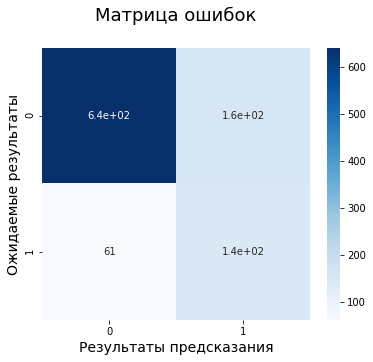

In [45]:
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(confusion_matrix(y_test, rf_prediction), annot=True, cmap='Blues')
sns.set_style('white')
heatmap.set_title('Матрица ошибок' + "\n", fontsize=18);
heatmap.set_xlabel('Результаты предсказания', fontsize=14);
heatmap.set_ylabel('Ожидаемые результаты', fontsize=14);
plt.show()

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Модель показала хорошие результаты, значит можно использовать её для прогнозирования.</b>
   </p>  
</div>

## 9 Отчёт

<hr style="color: steelblue; background-color: steelblue; height: 5px; border: none;">

### Описание ключевых шагов решения
1. При подготовке данных были удалены ненужные столбцы, обработаны пропуски, закодированы категориальные переменные, данные разбиты на выборки и масштабированы численные признаки.
1. При исследовании задачи выяснилось, что разница точностей моделей и фиктивного классификатора меньше 0.1, что означало, что в данных присутствовал сильный дисбаланс классов, что плохо сказывалось на обучении моделей.
1. Были выявлены лучшие методы борьбы с дисбалансом:
   - Для дерева решений — увеличение выборки.
   - Для логистической регрессии — взвешивание классов.
   - Для случайного леса — уменьшение выборки.
1. Также, были выявлены лучшие пороги классификации:
   - Для логистической регрессии — 0.5.
   - Для дерева решений — 0.
   - Для случайного леса — 0.6.
1. После подбора гиперпараметров стало понятно следующее:
   - Самая высокая точность у случайного леса, самая низкая у логистической регресии.
   - Самое быстрое время работы у дерева решений, самое медленное у логистической регресии.
1. Лучшая модель была протестирована, её предсказание бвло оценено.

***

### Описание модели
Модель — `RandomForestClassifier`.

Гиперпараметры:
- `random_state` = 0
- `max_depth` = 94
- `max_features` = 3
- `min_samples_leaf` = 40
- `min_samples_split` = 2
- `n_estimators` = 15

***

### Итоговая метрика
accuracy 0.78

<hr style="color: steelblue; background-color: steelblue; height: 5px; border: none;">